# Masking



In [1]:
import pyrasterframes
from pyrasterframes.utils import create_rf_spark_session
from pyrasterframes.rasterfunctions import *
import pyrasterframes.rf_ipython
from IPython.display import display
import pandas as pd
import numpy as np
from pyrasterframes.rf_types import Tile

spark = create_rf_spark_session()


Masking is a common operation in raster processing. It is setting certain cells to the @ref:[NoData value](nodata-handling.md). This is usually done to remove low-quality observations from the raster processing. Another related use case is to @ref:["clip"](masking.md#clipping) a raster to a given polygon.  

In this section we will demonstrate two common schemes for masking. In Sentinel 2, there is a separate classification raster that defines low quality areas. In Landsat 8, several quality factors are measured and the indications are packed into a single integer, which we have to unpack.
 
## Masking Sentinel 2

Let's demonstrate masking with a pair of bands of Sentinel-2 data. The measurement bands we will use, blue and green, have no defined NoData. They share quality information from a separate file called the scene classification (SCL), which delineates areas of missing data and probable clouds. For more information on this, see the [Sentinel-2 algorithm overview](https://earth.esa.int/web/sentinel/technical-guides/sentinel-2-msi/level-2a/algorithm). Figure 3 tells us how to interpret the scene classification. For this example, we will exclude NoData, defective pixels, probable clouds, and cirrus clouds: values 0, 1, 8, 9, and 10.

![Sentinel-2 Scene Classification Values](static/sentinel-2-scene-classification-labels.png)

Credit: [Sentinel-2 algorithm overview](https://earth.esa.int/web/sentinel/technical-guides/sentinel-2-msi/level-2a/algorithm)

The first step is to create a catalog with our band of interest and the SCL band. We read the data from the catalog, so all _tiles_ are aligned across rows.



In [2]:
from pyspark.sql import Row

blue_uri = 'https://s22s-test-geotiffs.s3.amazonaws.com/luray_snp/B02.tif'
green_uri = 'https://s22s-test-geotiffs.s3.amazonaws.com/luray_snp/B03.tif'
scl_uri = 'https://s22s-test-geotiffs.s3.amazonaws.com/luray_snp/SCL.tif'
cat = spark.createDataFrame([Row(blue=blue_uri, green=green_uri, scl=scl_uri),])
unmasked = spark.read.raster(cat, catalog_col_names=['blue', 'green', 'scl'])
unmasked.printSchema()

root
 |-- blue_path: string (nullable = false)
 |-- green_path: string (nullable = false)
 |-- scl_path: string (nullable = false)
 |-- blue: struct (nullable = true)
 |    |-- tile_context: struct (nullable = true)
 |    |    |-- extent: struct (nullable = false)
 |    |    |    |-- xmin: double (nullable = false)
 |    |    |    |-- ymin: double (nullable = false)
 |    |    |    |-- xmax: double (nullable = false)
 |    |    |    |-- ymax: double (nullable = false)
 |    |    |-- crs: struct (nullable = false)
 |    |    |    |-- crsProj4: string (nullable = false)
 |    |-- tile: tile (nullable = false)
 |-- green: struct (nullable = true)
 |    |-- tile_context: struct (nullable = true)
 |    |    |-- extent: struct (nullable = false)
 |    |    |    |-- xmin: double (nullable = false)
 |    |    |    |-- ymin: double (nullable = false)
 |    |    |    |-- xmax: double (nullable = false)
 |    |    |    |-- ymax: double (nullable = false)
 |    |    |-- crs: struct (nullable = fal

In [3]:
unmasked.select(rf_cell_type('blue'), rf_cell_type('scl')).distinct()

DataFrame[rf_cell_type(blue): struct<cellTypeName:string>, rf_cell_type(scl): struct<cellTypeName:string>]


### Define CellType for Masked Tile

Because there is not a NoData already defined for the blue band, we must choose one. If we try to apply a masking function to a tile whose cell type has no NoData defined, an error will be thrown. 
 
In this particular example, the minimum value of all cells in all tiles in the column is greater than zero, so we can use 0 as the NoData value. We will construct a new `CellType` object to represent this. 



In [4]:
blue_min = unmasked.agg(rf_agg_stats('blue').min.alias('blue_min'))
print('Nonzero minimum value in the blue band:', blue_min.first())

blue_ct = unmasked.select(rf_cell_type('blue')).distinct().first()[0][0]
masked_blue_ct = CellType(blue_ct).with_no_data_value(0)
masked_blue_ct.cell_type_name

Nonzero minimum value in the blue band: Row(blue_min=3.0)


'uint16ud0'


We next convert the blue band to this cell type.



In [5]:
converted = unmasked.select('scl', 'green', rf_convert_cell_type('blue', masked_blue_ct).alias('blue'))


### Apply Mask from Quality Band

Now we set cells of our `blue` column to NoData for all locations where the `scl` tile is in our set of undesirable values. This is the actual _masking_ operation.



DataFrame[scl: struct<tile_context:struct<extent:struct<xmin:double,ymin:double,xmax:double,ymax:double>,crs:struct<crsProj4:string>>,tile:udt>, green: struct<tile_context:struct<extent:struct<xmin:double,ymin:double,xmax:double,ymax:double>,crs:struct<crsProj4:string>>,tile:udt>, blue: struct<tile_context:struct<extent:struct<xmin:double,ymin:double,xmax:double,ymax:double>,crs:struct<crsProj4:string>>,tile:udt>, blue_masked: struct<tile_context:struct<extent:struct<xmin:double,ymin:double,xmax:double,ymax:double>,crs:struct<crsProj4:string>>,tile:udt>]
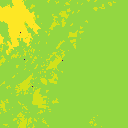
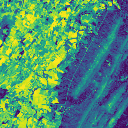
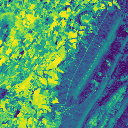
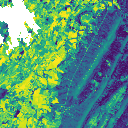
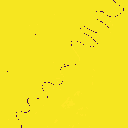
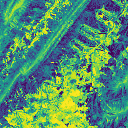
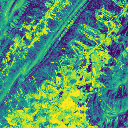
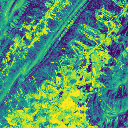
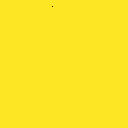
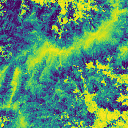
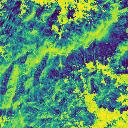
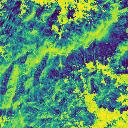
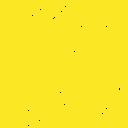
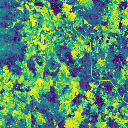
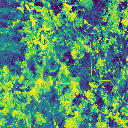
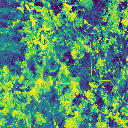
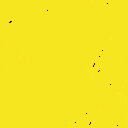
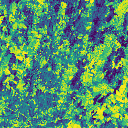
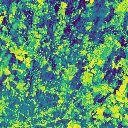
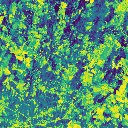

In [6]:
from pyspark.sql.functions import lit

masked = converted.withColumn('blue_masked', rf_mask_by_values('blue', 'scl', [0, 1, 8, 9, 10]))
masked


We can verify that the number of NoData cells in the resulting `blue_masked` column matches the total of the boolean `mask` _tile_ to ensure our logic is correct.



In [7]:
masked.select(rf_no_data_cells('blue_masked'), rf_tile_sum(rf_local_is_in('scl', [0, 1, 8, 9, 10])))

DataFrame[rf_no_data_cells(blue_masked): bigint, rf_tile_sum(rf_local_is_in(scl, array(0, 1, 8, 9, 10))): double]


It's also nice to view a sample. The white regions are areas of NoData.



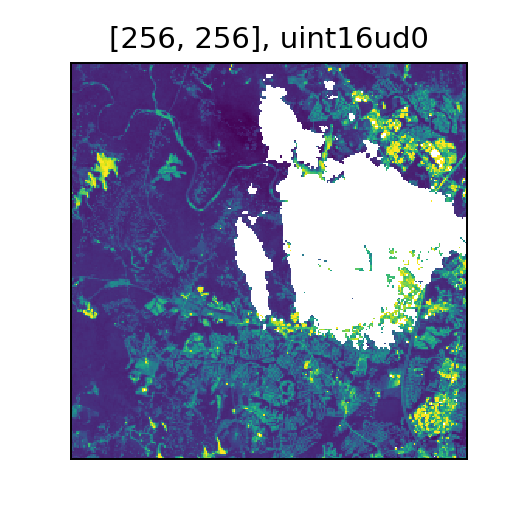

In [8]:
sample = masked.orderBy(-rf_no_data_cells('blue_masked')).select(rf_tile('blue_masked'), rf_tile('scl')).first()
display(sample[0])


And the original SCL data. The bright yellow is a cloudy region in the original image.



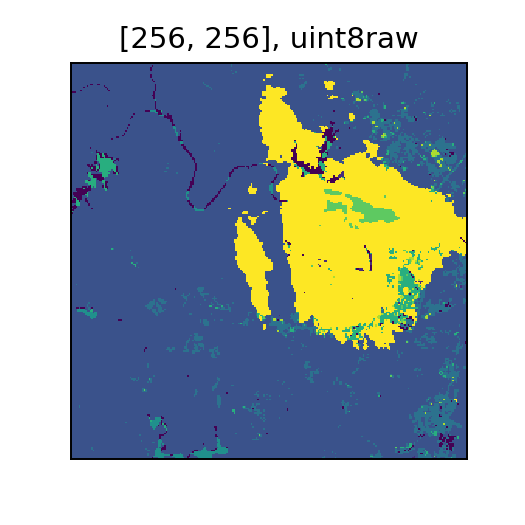

In [9]:
display(sample[1])


### Transferring Mask

We can now apply the same mask from the blue column to the green column. Note here we have supressed the step of explicitly checking what a "safe" NoData value for the green band should be.  



DataFrame[scl: struct<tile_context:struct<extent:struct<xmin:double,ymin:double,xmax:double,ymax:double>,crs:struct<crsProj4:string>>,tile:udt>, green: struct<tile_context:struct<extent:struct<xmin:double,ymin:double,xmax:double,ymax:double>,crs:struct<crsProj4:string>>,tile:udt>, blue: struct<tile_context:struct<extent:struct<xmin:double,ymin:double,xmax:double,ymax:double>,crs:struct<crsProj4:string>>,tile:udt>, blue_masked: struct<tile_context:struct<extent:struct<xmin:double,ymin:double,xmax:double,ymax:double>,crs:struct<crsProj4:string>>,tile:udt>, green_masked: struct<tile_context:struct<extent:struct<xmin:double,ymin:double,xmax:double,ymax:double>,crs:struct<crsProj4:string>>,tile:udt>]
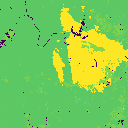
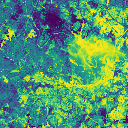
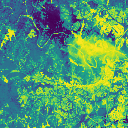
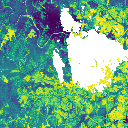
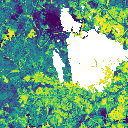
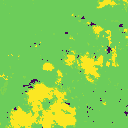
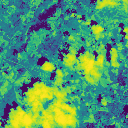
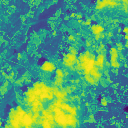
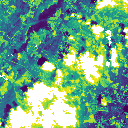
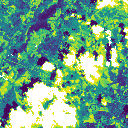
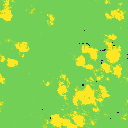
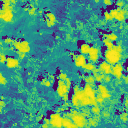
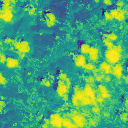
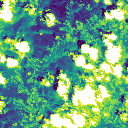
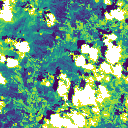
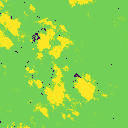
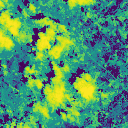
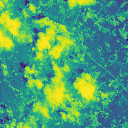
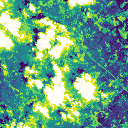
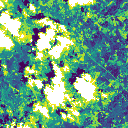
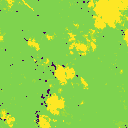
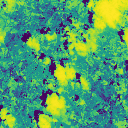
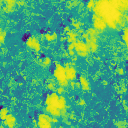
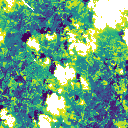
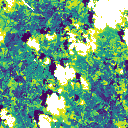

In [10]:
masked.withColumn('green_masked', rf_mask(rf_convert_cell_type('green', masked_blue_ct), 'blue_masked'))  \
      .orderBy(-rf_no_data_cells('blue_masked'))


## Masking Landsat 8


We will work with the Landsat scene [here](https://landsat-pds.s3.us-west-2.amazonaws.com/c1/L8/153/075/LC08_L1TP_153075_20190718_20190731_01_T1/index.html). For simplicity, we will just use two of the seven 30m bands. The quality mask for all bands is all contained in the `BQA` band. 




In [11]:
base_url = 'https://landsat-pds.s3.us-west-2.amazonaws.com/c1/L8/153/075/LC08_L1TP_153075_20190718_20190731_01_T1/LC08_L1TP_153075_20190718_20190731_01_T1_'
data4 = base_url + 'B4.TIF'
data2 = base_url + 'B2.TIF'
mask = base_url + 'BQA.TIF'
l8_df = spark.read.raster([[data4, data2, mask]]) \
               .withColumnRenamed('proj_raster_0', 'data') \
               .withColumnRenamed('proj_raster_1', 'data2') \
               .withColumnRenamed('proj_raster_2', 'mask')


Masking is described [on the Landsat Missions page](https://www.usgs.gov/land-resources/nli/landsat/landsat-collection-1-level-1-quality-assessment-band). It is pretty dense. Focus for this data set is the Collection 1 Level-1 for Landsat 8. 
 
There are several inter-related factors to consider. In this exercise we will mask away the following.
 
 * Designated Fill = yes
 * Cloud = yes
 * Cloud Shadow Confidence = Medium or High
 * Cirrus Confidence = Medium or High
 
Note that you should consider your application and do your own exploratory analysis to determine the most appropriate mask!
 
According to the information on the Landsat site this translates to masking by bit values in the BQA according to the following table.
 
| Description        	| Value    	| Bits  	| Bit values     	|
|--------------------	|----------	|-------	|----------------	|
| Designated fill    	| yes      	| 0     	| 1              	|
| Cloud              	| yes      	| 4     	| 1              	|
| Cloud shadow conf. 	| med / hi 	| 7-8   	| 10, 11 (2, 3)  	|
| Cirrus conf.       	| med / hi 	| 11-12 	| 10, 11 (2, 3)  	|


In this case, we will use the value of 0 as the NoData in the band data. Inspecting the associated [MTL txt file](https://landsat-pds.s3.us-west-2.amazonaws.com/c1/L8/153/075/LC08_L1TP_153075_20190718_20190731_01_T1/LC08_L1TP_153075_20190718_20190731_01_T1_MTL.txt) By inspection, we can discover that the minimum value in the band will be 1, thus allowing our use of 0 for NoData.

The code chunk below works through each of the rows in the table above. The first expression sets the cell type to have the selected NoData. The @ref:[`rf_mask_by_bit`](reference.md#rf-mask-by-bit) and @ref:[`rf_mask_by_bits`](reference.md#rf-mask-by-bits) functions extract the selected bit or bits from the `mask` cells and compare them to the provided values.



DataFrame[data: struct<tile_context:struct<extent:struct<xmin:double,ymin:double,xmax:double,ymax:double>,crs:struct<crsProj4:string>>,tile:udt>, mask: struct<tile_context:struct<extent:struct<xmin:double,ymin:double,xmax:double,ymax:double>,crs:struct<crsProj4:string>>,tile:udt>, data_masked: struct<tile_context:struct<extent:struct<xmin:double,ymin:double,xmax:double,ymax:double>,crs:struct<crsProj4:string>>,tile:udt>, data2: struct<tile_context:struct<extent:struct<xmin:double,ymin:double,xmax:double,ymax:double>,crs:struct<crsProj4:string>>,tile:udt>, rf_extent(data_masked): struct<xmin:double,ymin:double,xmax:double,ymax:double>]
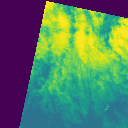
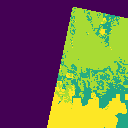
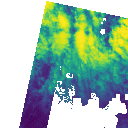
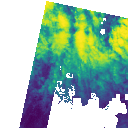
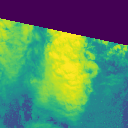
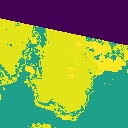
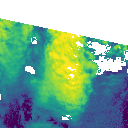
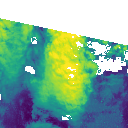
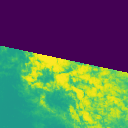
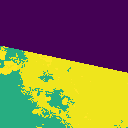
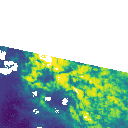
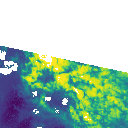
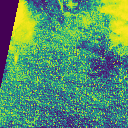
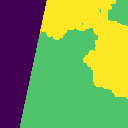
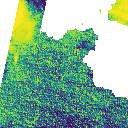
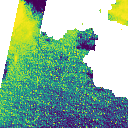
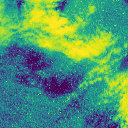
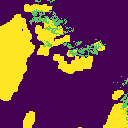
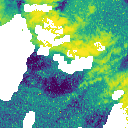
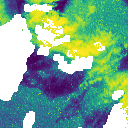

In [12]:
l8_df = l8_df.withColumn('data_masked', # set to cell type that has a nodata 
                   rf_convert_cell_type('data', CellType.uint16())) \
       .withColumn('data_masked', # fill yes 
                  rf_mask_by_bit('data_masked', 'mask', 0, 1)) \
       .withColumn('data_masked', # cloud yes
                  rf_mask_by_bit('data_masked', 'mask', 4, 1)) \
       .withColumn('data_masked', # cloud shadow conf is medium or high
                  rf_mask_by_bits('data_masked', 'mask', 7, 2, [2, 3])) \
       .withColumn('data_masked', # cloud shadow conf is medium or high
                  rf_mask_by_bits('data_masked', 'mask', 11, 2, [2, 3])) \
       .withColumn('data2', # mask other data col against the other band
                  rf_mask(rf_convert_cell_type('data2',CellType.uint16()), 'data_masked')) \
       .filter(rf_data_cells('data_masked') > 0) # remove any entirely ND rows

# Inspect a sample
l8_df.select('data', 'mask', 'data_masked', 'data2', rf_extent('data_masked')) \
     .filter(rf_data_cells('data_masked') > 32000)



## Clipping

Clipping is the use of a polygon to determine the areas to mask in a raster. Typically the areas inside a polygon are retained and the cells outside are set to NoData. Given a geometry column on our DataFrame, we have to carry out three basic steps. First we have to ensure the vector geometry is correctly projected to the same @ref:[CRS](concepts.md#coordinate-reference-system-crs) as the raster. We'll continue with our Sentinel 2 example, creating a simple polygon. Buffering a point will create an approximate circle.




In [13]:
to_rasterize = masked.withColumn('geom_4326', 
                            st_bufferPoint(
                                st_point(lit(-78.0783132), lit(38.3184340)), 
                                lit(15000))) \
                .withColumn('geom_native', st_reproject('geom_4326', rf_mk_crs('epsg:4326'), rf_crs('blue_masked')))


Second, we will rasterize the geometry, or burn-in the geometry into the same grid as the raster.



DataFrame[blue_masked: struct<tile_context:struct<extent:struct<xmin:double,ymin:double,xmax:double,ymax:double>,crs:struct<crsProj4:string>>,tile:udt>, clip_raster: udt]
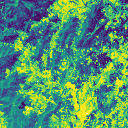
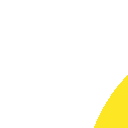
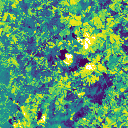
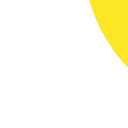
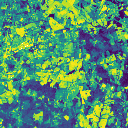
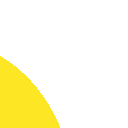
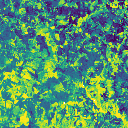
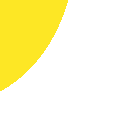
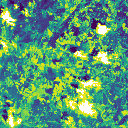
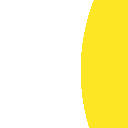

In [14]:
to_clip = to_rasterize.withColumn('clip_raster', 
                                 rf_rasterize('geom_native', rf_geometry('blue_masked'), lit(1), rf_dimensions('blue_masked').cols, rf_dimensions('blue_masked').rows))

# visualize some of the edges of our circle
to_clip.select('blue_masked', 'clip_raster') \
    .filter(rf_data_cells('clip_raster') > 20) \
    .orderBy(rf_data_cells('clip_raster'))


Finally, we create a new _tile_ column with the blue band clipped to our circle. Again we will use the `rf_mask` function to pass the NoData regions along from the rasterized geometry.



DataFrame[blue_masked: struct<tile_context:struct<extent:struct<xmin:double,ymin:double,xmax:double,ymax:double>,crs:struct<crsProj4:string>>,tile:udt>, clip_raster: udt, blue_clipped: struct<tile_context:struct<extent:struct<xmin:double,ymin:double,xmax:double,ymax:double>,crs:struct<crsProj4:string>>,tile:udt>]
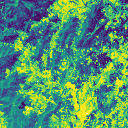
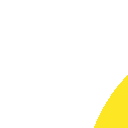
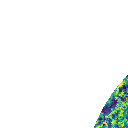
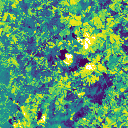
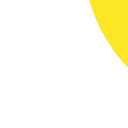
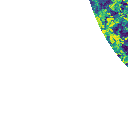
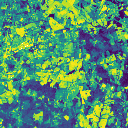
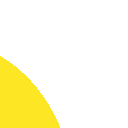
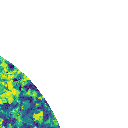
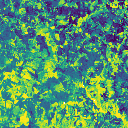
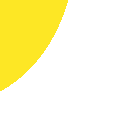
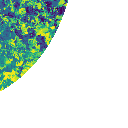
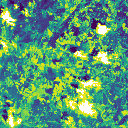
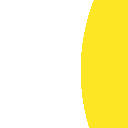
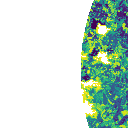

In [15]:
to_clip.select('blue_masked', 
               'clip_raster',
               rf_mask('blue_masked', 'clip_raster').alias('blue_clipped')) \
           .filter(rf_data_cells('clip_raster') > 20) \
           .orderBy(rf_data_cells('clip_raster'))


This kind of clipping technique is further used in @ref:[zonal statistics](zonal-algebra.md).
